# Journey through some Exploration Algorithms

### Introduction: 

This tutorial explains and implements some exploration algorithms used in developmental robotics.
We use the [Explauto](https://github.com/flowersteam/explauto) Python library as a toolkit to 

The progression is the following:

    I.   Exploring by hand the movements of a robotic arm
    II.  Random Motor Babbling
    III. Random Goal Babbling
    IV.  Active Goal Babbling
    V.   More complex environment
    VI.  Active Model Babbling

### Requirements:

- Python 2.7, Numpy, Scipy, Scikit-learn and [Jupyter](http://jupyter.readthedocs.io/en/latest/install.html). For users not familiar with Python, installing [Anaconda](https://www.continuum.io/downloads) for Python 2.7 includes all of them.
- [Explauto](https://github.com/flowersteam/explauto), the Python Library for Autonomous Exploration. See [installation](http://flowersteam.github.io/explauto/installation.html) section: the simplest is to install explauto via pip: 'pip install explauto'.

You might need to run 'jupyter nbextension enable --py --sys-prefix widgetsnbextension' to enable the interaction with sliders in part I (it will tell you later).


To run this notebook, run the following command in the ExplorationAlgorithm folder:

    jupyter notebook main.ipynb
    
    
Let's begin with the import of all the classes and functions we will need in this notebook.

In [17]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
from numpy import pi, array, linspace, hstack, zeros, transpose
from matplotlib import animation
from IPython.display import HTML, display
from ipywidgets import interact_manual
from numpy.random import random, normal

from explauto import SensorimotorModel
from explauto.sensorimotor_model.non_parametric import NonParametric
from explauto import InterestModel
from explauto.interest_model.discrete_progress import DiscretizedProgress
from explauto.utils import rand_bounds, bounds_min_max, softmax_choice, prop_choice
from explauto.environment.dynamic_environment import DynamicEnvironment
from explauto.interest_model.competences import competence_exp, competence_dist
from explauto.environment.modular_environment import FlatEnvironment, HierarchicalEnvironment

from environment import Arm, Ball, Stick, Environment1, Environment2, Environment3
from learning_module import LearningModule
from utils import compute_explo

grid_size = 10

-------------------------------
#  I. Exploring by hand the movements of a robotic arm

This first part is designed to have a first experience of the complexity of the task given to the robot, by the exploration of the motor parameters by hand.

The 3 joints of the robotic arm are controlled through DMPs with 3 basis functions, which results in 9 motor parameters in total that produce a movement of the arm.

You can control those parameters by hand through the 9 following sliders (move the sliders and then hit "Run" button).

Try to catch the ball !

In [11]:
# Had to run 'jupyter nbextension enable --py --sys-prefix widgetsnbextension'
fig, ax = plt.subplots()

environment1 = Environment1()

def movement(m1=0., m2=0., m3=0., m4=0., m5=0., m6=0., m7=0., m8=0., m9=0.):
    environment1.update(array([m1, m2, m3, m4, m5, m6, m7, m8, m9]))
    display(HTML(environment1.plot(fig, ax)))
    
interact_manual(movement, m1=(-1., 1., 0.01), m2=(-1., 1., 0.01), m3=(-1., 1., 0.01), 
                          m4=(-1., 1., 0.01), m5=(-1., 1., 0.01), m6=(-1., 1., 0.01), 
                          m7=(-1., 1., 0.01), m8=(-1., 1., 0.01), m9=(-1., 1., 0.01))


-------------------------------
#  II. Random Motor Babbling

Now, let's use a higher dimensional arm (7 joints and 21 motor parameters), and see how the robot could explore how its arm works by just trying a lot of different random motor configurations, which is called Random Motor Babbling.

In the following, we do 1000 iterations of Random Motor Babbling and we plot the trajectory of the ball (and its last position) in the iterations where the ball was caught.

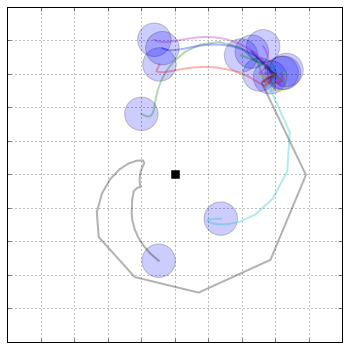

In [13]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim((-1., 1.))
ax.set_ylim((-1., 1.))
ax.plot(0., 0., 'sk', ms=8)
explored_s_mb = []

environment2 = Environment2()

for _ in range(1000):
    m = environment2.random_motors()[0]
    s = environment2.update(m)
    if abs(s[-1] - 0.6) > 0.001:
        explored_s_mb += [s]
        ax.plot(environment2.s_traj[:,0], environment2.s_traj[:,1], lw=2, alpha=0.3)
        ax.add_patch(Circle(tuple(environment2.s_traj[-1,:]), 0.1, fc="b", alpha=0.2))
        
plt.xticks(linspace(-1., 1., grid_size + 1))
plt.yticks(linspace(-1., 1., grid_size + 1))
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.grid()

### Exploration measure
We compute the number of cells in the above grid where the ball has been placed at the end of the different movements.

In [6]:
print "Number of ball catch:", len(explored_s_mb)
print "Number of reached cells:", int(compute_explo(array(explored_s_mb), array([-1., -1.]), array([1., 1.]), gs=grid_size))

Number of ball catch: 14
Number of reached cells: 8


We can see that the ball has been caught only a few times and that a small number of cells have been reached with the ball.

-------------------------------
#  III. Random Goal Babbling

Random Goal Babbling is a more efficient exploration algorithm.

Number of ball catch: 750
Number of reached cells: 51


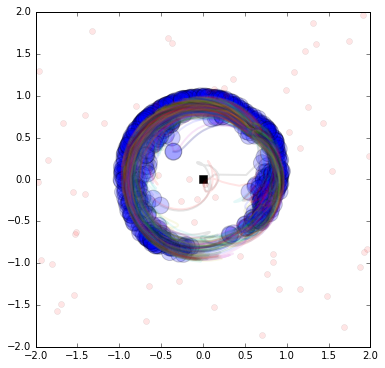

In [7]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim((-2., 2.))
ax.set_ylim((-2., 2.))
ax.plot(0., 0., 'sk', ms=8)
explored_s_gb = []

sm_model = SensorimotorModel.from_configuration(environment2.conf, 'nearest_neighbor', 'default')
sigma_explo_ratio = 0.05

# Bootstrap model: 1 random motor babbling
m = environment2.random_motors()[0]
s = environment2.update(m)
sm_model.update(m, s)
    
for _ in range(2000):
    if (not sm_model.bootstrapped_s) or random() < 0.2:
        m = environment2.random_motors()[0]
    else:
        s_goal = rand_bounds(environment2.conf.s_bounds)[0]
        # infer a motor command to reach that goal using the Nearest Neighbor algorithm:
        m = sm_model.model.infer_order(tuple(s_goal))
        # add exploration noise (of variance sigma) to experiment new motor parameters
        m = normal(m, sigma_explo_ratio)
        #Plot the goal
        ax.plot([s_goal[0]], [s_goal[1]], 'or', alpha=0.1)
        
    s = environment2.update(m)
    sm_model.update(m, s)
    if abs(s[-1] - 0.6) > 0.001:
        explored_s_gb += [s]
        ax.plot(environment2.s_traj[:,0], environment2.s_traj[:,1], lw=2, alpha=0.1)
        ax.add_patch(Circle(tuple(environment2.s_traj[-1,:]), ball_config["size"], fc=ball_config["color"], alpha=0.2))
        
print "Number of ball catch:", len(explored_s_gb)
print "Number of reached cells:", int(compute_explo(array(explored_s_gb), array([-1., -1.]), array([1., 1.]), gs=grid_size))

-------------------------------
# IV. Active Goal Babbling

Active learning can be helpful.

Number of ball catch: 655
Number of reached cells: 38


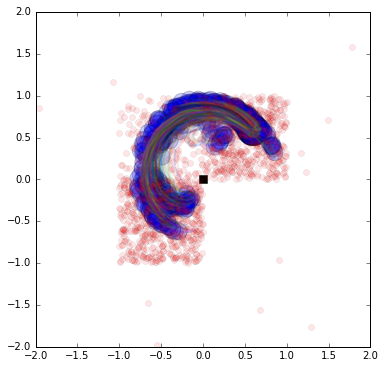

In [8]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim((-2, 2.))
ax.set_ylim((-2., 2.))
ax.plot(0., 0., 'sk', ms=8)
explored_s_agb = []


sm_model = SensorimotorModel.from_configuration(environment2.conf, 'nearest_neighbor', 'default')
sigma_explo_ratio = 0.05

im_n_cells = 20
im_model = DiscretizedProgress(environment2.conf, environment2.conf.s_dims, 
                               **{'x_card': im_n_cells*im_n_cells, 
                                  'win_size': 20, 
                                  'eps_random': 0.2,
                                  'measure': competence_dist})

# Bootstrap model: 1 random motor babbling
m = environment2.random_motors()[0]
s = environment2.update(m)
sm_model.update(m, s)
    
for _ in range(2000):
    if (not sm_model.bootstrapped_s) or random() < 0.2:
        m = environment2.random_motors()[0]
        s = environment2.update(m)
        sm_model.update(m, s)
    else:
        # sample a sensory goal maximizing learning progress using the interest model:
        s_goal = im_model.sample()
        # infer a motor command to reach that goal using the Nearest Neighbor algorithm:
        m = sm_model.model.infer_order(tuple(s_goal))
        # add exploration noise (of variance sigma) to experiment new motor parameters
        m = normal(m, sigma_explo_ratio)
        # execute this command and observe the corresponding sensory effect:
        s = environment2.update(m)
        # update the sensorimotor model:
        sm_model.update(m, s)
        # update the interest model:
        im_model.update(hstack((m, s_goal)), hstack((m, s)))
        #Plot the goal
        ax.plot([s_goal[0]], [s_goal[1]], 'or', alpha=0.1)
    # plot the observed sensory effect:
    if abs(s[-1] - 0.6) > 0.001:
        explored_s_agb += [s]
        ax.plot(environment2.s_traj[:,0], environment2.s_traj[:,1], lw=2, alpha=0.1)
        ax.add_patch(Circle(tuple(environment2.s_traj[-1,:]), ball_config["size"], fc=ball_config["color"], alpha=0.2))

print "Number of ball catch:", len(explored_s_agb)
print "Number of reached cells:", int(compute_explo(array(explored_s_agb), array([-1., -1.]), array([1., 1.]), gs=grid_size))

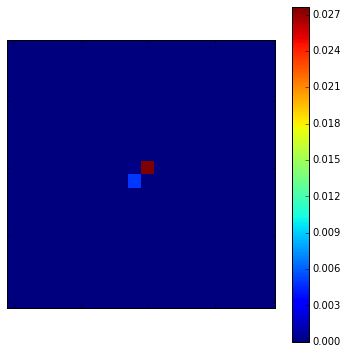

In [9]:
progress_flat = abs(im_model.discrete_progress.progress())
progress_array = zeros(im_model.space.cardinalities)

for idx in range(len(progress_flat)):
    progress_array[im_model.space.index2multi(idx)] = progress_flat[idx]
    #print "xy", im_model.space.index2multi(idx), "progress", progress_flat[idx], im_model.discrete_progress.queues[idx]

from matplotlib import cm
fig, ax = plt.subplots()
ax.set_xticklabels([])
ax.set_yticklabels([])
cax = ax.imshow(transpose(progress_array), origin='lower', cmap=cm.jet, interpolation="none")
fig.colorbar(cax)


RGB seems as good as AGB. 

Intuition: normally RGB explores more the frontier and has trouble to reach the inside, but here it could be that from a point reaching the frontier, the random exploration noise easily allows to reach the inside (it is sufficient to change only one of 14 parameters, or even combinations of them).

-------------------------------
# V. More complex environment

Test AGB

In [2]:
environment3 = Environment3()

[ 0.30611635  0.24330422  0.52476102  0.05698496 -0.08757985  0.41088337
 -0.96213203 -0.96213203 -0.96213203  0.46213203  0.46213203  0.46213203
  0.6         0.6         0.6         0.6         0.6         0.6        -0.6
 -0.6        -0.6         0.6         0.6         0.6         0.11855235
 -1.35092641 -2.          1.86466135  2.          1.04468518  1.19688968
  2.          1.93440091  0.28114388  1.37550592  1.98441458]


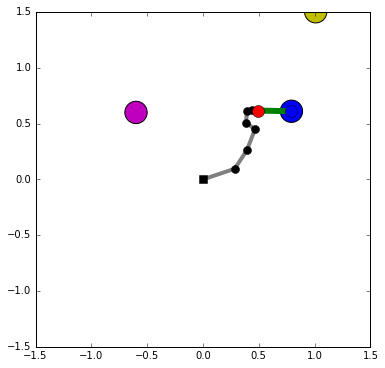

In [11]:
fig, ax = plt.subplots()

# Random Motor Babbling
m = environment3.random_motors()[0]
s = environment3.update(m)
print s
display(HTML(environment3.plot(fig, ax)))

# Example of motor parameters to catch the ball (around 1 out of 10000 random motor parameters)
m = [ 0.54984069,  0.02455233, -0.59603529, -0.6655813,   0.33923315,  0.22605509,
  0.81641894, -0.26901228,  0.14363993, -0.71148838,  0.10504532,  0.58099297,
 -0.80227669,  0.48208766, -0.56107818, -0.68042166,  0.9648434,  -0.8760082,
 -0.19469749, -0.6141873,   0.11389673]
s = environment3.update(m)
display(HTML(environment3.plot(fig, ax)))


for i in range(1000):
    m = environment3.random_motors()[0]

    s = environment3.update(m)
    if abs(s[17] - 0.6) > 0.001:
        print "Iteration", i, "m", m, "s", s
        display(HTML(environment3.plot(fig, ax)))

Now Random Goal Babbling on trajectories of arm, tool and balls (30 dimensions):

Number of tool catch: 8067
Number of cells reached with tool: 32
Number of ball catch: 1144
Number of cells reached with ball: 9


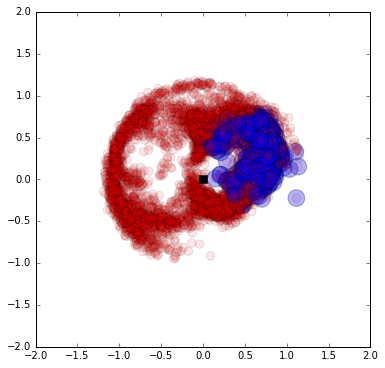

In [10]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim((-2, 2.))
ax.set_ylim((-2., 2.))
ax.plot(0., 0., 'sk', ms=8)
explored_s_agb_t = []
explored_s_agb_o = []

def plot_s(s):
    global explored_s_agb_t, explored_s_agb_o
    if abs(s[17] - 0.6) > 0.001:
        explored_s_agb_o += [[s[14], s[17]]]
        ax.add_patch(Circle(tuple(environment3.s_traj[-1,4:6]), 0.1, fc="b", alpha=0.3))
    if abs(s[11] - 0.46213203) > 0.001:
        explored_s_agb_t += [[s[8], s[11]]]
        ax.add_patch(Circle(tuple(environment3.s_traj[-1,2:4]), 0.05, fc="r", alpha=0.1))
        
        
sm_model = SensorimotorModel.from_configuration(environment3.conf, 'nearest_neighbor', 'default')
sigma_explo_ratio = 0.05


# Bootstrap model: 1 random motor babbling
m = environment3.random_motors()[0]
s = environment3.update(m)
sm_model.update(m, s)
    
for _ in range(100000):
    if (not sm_model.bootstrapped_s) or random() < 0.2:
        m = environment3.random_motors()[0]
        s = environment3.update(m)
        sm_model.update(m, s)
    else:
        # sample a sensory goal maximizing learning progress using the interest model:
        s_goal = rand_bounds(environment3.conf.s_bounds)[0]
        # infer a motor command to reach that goal using the Nearest Neighbor algorithm:
        m = sm_model.model.infer_order(tuple(s_goal))
        # add exploration noise (of variance sigma) to experiment new motor parameters:
        m = normal(m, sigma_explo_ratio)
        # execute this command and observe the corresponding sensory effect:
        s = environment3.update(m)
        # update the sensorimotor model:
        sm_model.update(m, s)
    plot_s(s) # plot the observed sensory effect

        
print "Number of tool catch:", len(explored_s_agb_t)
print "Number of cells reached with tool:", int(compute_explo(array(explored_s_agb_t), array([-2., -2.]), array([2., 2.]), gs=grid_size))
print "Number of ball catch:", len(explored_s_agb_o)
print "Number of cells reached with ball:", int(compute_explo(array(explored_s_agb_o), array([-2., -2.]), array([2., 2.]), gs=grid_size))

Active Goal Babbling can't directly help in 30 dimensions

=> Need to change the representation

-------------------------------
# VI. Model Babbling

Use algo and interest measure from IROS

To measure the interest of each module, we pick one module, pick one random goal in its sensory space, and do 5 iterations with this goal: 4 with gaussian exploration noise, and 1 without noise, an unperturbated reached sensory point used to compute errors and progress.

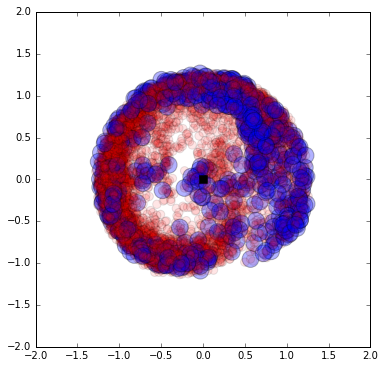

In [14]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim((-2, 2.))
ax.set_ylim((-2., 2.))
ax.plot(0., 0., 'sk', ms=8)
explored_s_agb_t = []
explored_s_agb_o = []
interests_evolution = []
n_explore = 4

def plot_s(s):
    global explored_s_agb_t, explored_s_agb_o
    if abs(s[17] - 0.6) > 0.001:
        explored_s_agb_o += [[s[14], s[17]]]
        ax.add_patch(Circle(tuple(environment3.s_traj[-1,4:6]), 0.1, fc="b", alpha=0.3))
    if abs(s[11] - 0.46213203) > 0.001:
        explored_s_agb_t += [[s[8], s[11]]]
        ax.add_patch(Circle(tuple(environment3.s_traj[-1,2:4]), 0.05, fc="r", alpha=0.1))
        
    
# Create environment:
environment3 = Environment3()

# Define motor and sensory spaces:
m_space = range(21)
s_hand = range(21, 27)
s_tool = range(27, 33)
s_ball1 = range(33, 39)
s_ball2 = range(39, 45)
s_ball3 = range(45, 51)
s_ball4 = range(51, 57)

# Create 6 learning modules:
learning_modules = {}
learning_modules['mod1'] = LearningModule("mod1", m_space, s_hand, environment3.conf)
learning_modules['mod2'] = LearningModule("mod2", m_space, s_tool, environment3.conf)
learning_modules['mod3'] = LearningModule("mod3", m_space, s_ball1, environment3.conf)
learning_modules['mod4'] = LearningModule("mod4", m_space, s_ball2, environment3.conf)
learning_modules['mod5'] = LearningModule("mod5", m_space, s_ball3, environment3.conf)
learning_modules['mod6'] = LearningModule("mod6", m_space, s_ball4, environment3.conf)


# 1000 steps of (4 exploring and 1 exploiting iterations):
for step in range(100000 / (n_explore + 1)):
    interests = [learning_modules[mid].interest() for mid in learning_modules.keys()] # compute the interest of modules
    interests_evolution.append(interests)
    # choose the babbling module (probabilities proportional to interests, with epsilon of random choice):
    babbling_module = learning_modules.values()[prop_choice(interests, eps=0.2)]
    # the babbling module picks a random goal in its sensory space and returns 4 noisy motor commands:
    m_list = babbling_module.produce(n=n_explore)
    for m in m_list:
        s = environment3.update(m) # execute this command and observe the corresponding sensory effect
        plot_s(s) # plot the observed sensory effect
        # Update sensorimotor models:
        for mid in learning_modules.keys():
            learning_modules[mid].update_sm(m, learning_modules[mid].get_s(array(list(m) + list(s))))
    # choose the best motor command to reach current goal (with no noise):
    m = babbling_module.infer(babbling_module.expl_dims, babbling_module.inf_dims, babbling_module.x, n=1, explore=False)    
    s = environment3.update(m) # execute this command and observe the corresponding sensory effect
    # update the 5 sensorimotor models and the interest model of the babbling module:
    for mid in learning_modules.keys():
        learning_modules[mid].perceive(m, learning_modules[mid].get_s(array(list(m)+list(s))), mid==babbling_module.mid)
        


In [15]:
for mid in learning_modules.keys():
    print "Number of babbling steps for module", mid, ":", learning_modules[mid].im.n_points(), "{}%".format(int(100. * (n_explore + 1)*learning_modules[mid].im.n_points() / float(learning_modules[mid].sm.t)))
print
    
        
print "Number of tool catch:", len(explored_s_agb_t)
print "Number of cells reached with tool:", int(compute_explo(array(explored_s_agb_t), array([-2., -2.]), array([2., 2.]), gs=grid_size))
print "Number of ball catch:", len(explored_s_agb_o)
print "Number of cells reached with ball:", int(compute_explo(array(explored_s_agb_o), array([-2., -2.]), array([2., 2.]), gs=grid_size))

Number of babbling steps for module mod1 : 5723 28%
Number of babbling steps for module mod2 : 6371 31%
Number of babbling steps for module mod3 : 5073 25%
Number of babbling steps for module mod4 : 663 3%
Number of babbling steps for module mod5 : 1207 6%
Number of babbling steps for module mod6 : 953 4%

Number of tool catch: 7109
Number of cells reached with tool: 43
Number of ball catch: 562
Number of cells reached with ball: 40


AMB explores better than F-RGB

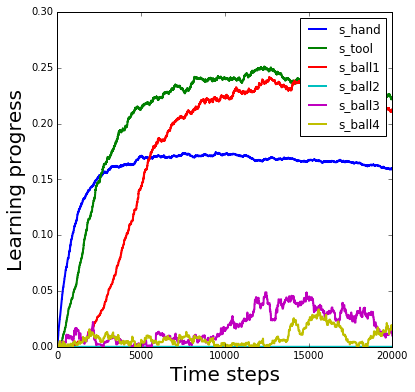

In [16]:
fig, ax = plt.subplots()
ax.plot(array(interests_evolution), lw=2)
ax.legend(["s_hand", "s_tool", "s_ball1", "s_ball2", "s_ball3", "s_ball4"])
ax.set_xlabel('Time steps', fontsize=20)
ax.set_ylabel('Learning progress', fontsize=20)

The interest of the static ball is always 0.
The interest of random balls is small.
The interest of hand is high at the beginning and allows to explore movements of the hand and to discover the tool (no other motor babbling).
